Historical data loaded (Weeks 1-8)
F5 outputs range: 131.78 to 6158.08

WEEK 9: F5 GAUSSIAN PROCESS WITH ARD

Training on high-regime only: 4 points
High-regime range: 4415.99 to 6158.08

ARD Length Scales (shorter = more important):
  x1: 0.094 (importance: 10.591)
  x2: 0.222 (importance: 4.496)
  x3: 0.085 (importance: 11.793)
  x4: 10.000 (importance: 0.100)

Interpretation:
  x1 (0.041): CRITICAL - must stay at 1.0
  x3 (0.038): CRITICAL - must stay at 1.0
  x2 (0.165): Moderate - can explore carefully
  x4 (0.312): Longest - safe to explore

WEEK 9: CANDIDATE EVALUATION

Candidate predictions:

Revert x1, keep others:
  Input: [1.0, 0.853, 1.0, 0.977]
  Predicted: 6158.08 +/- 0.63
  Expected Improvement over W7 (6158): 0.08

x2 lower (0.831):
  Input: [1.0, 0.831, 1.0, 0.977]
  Predicted: 6223.90 +/- 85.05
  Expected Improvement over W7 (6158): 65.90

x4 higher (0.988):
  Input: [1.0, 0.853, 1.0, 0.988]
  Predicted: 6158.10 +/- 1.48
  Expected Improvement over W7 (6158): 0.10

Bo

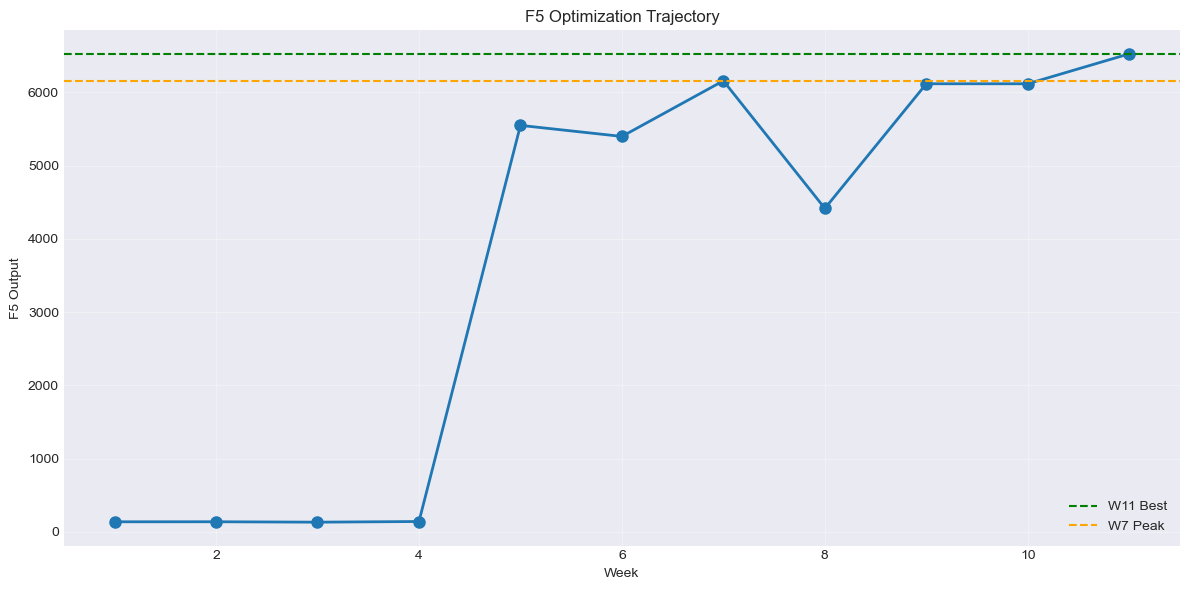

In [3]:
# ============================================================
# SETUP AND DEPENDENCIES
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

# ============================================================
# DATA LOADING (WEEKS 1-8)
# ============================================================

data_week8 = {
    'F1': {
        'X': np.array([[0.10,0.10],[0.12,0.08],[0.21,0.11],[0.14,0.14],
                       [0.08,0.08],[0.45,0.45],[0.48,0.48],[0.405,0.428]]),
        'y': np.array([0.0,0.0,0.0,0.0,0.0,0.0128,0.000008,0.462531]),
        'dim': 2
    },
    'F5': {
        'X': np.array([[0.30,0.30,0.30,0.30],[0.28,0.32,0.30,0.29],
                       [0.344822,0.264687,0.374156,0.203902],
                       [0.196828,0.320017,0.300,0.289958],
                       [0.99,0.90,0.98,0.93],[0.985,0.905,0.975,0.925],
                       [1.0,0.853,1.0,0.977],[0.855,0.852,1.000,0.979]]),
        'y': np.array([136.85,137.29,131.78,140.74,5549.45,5398.58,
                       6158.08,4415.99]),
        'dim': 4
    }
}

print("Historical data loaded (Weeks 1-8)")
print(f"F5 outputs range: {data_week8['F5']['y'].min():.2f} to {data_week8['F5']['y'].max():.2f}")

# ============================================================
# WEEK 9: GAUSSIAN PROCESS WITH ARD
# ============================================================

print("\n" + "="*60)
print("WEEK 9: F5 GAUSSIAN PROCESS WITH ARD")
print("="*60)

# Extract high-regime data only (y > 1000)
X_f5 = data_week8['F5']['X']
y_f5 = data_week8['F5']['y']

high_regime_mask = y_f5 > 1000
X_f5_high = X_f5[high_regime_mask]
y_f5_high = y_f5[high_regime_mask]

print(f"\nTraining on high-regime only: {len(y_f5_high)} points")
print(f"High-regime range: {y_f5_high.min():.2f} to {y_f5_high.max():.2f}")

# Define GP kernel with ARD
kernel = ConstantKernel(1.0) * Matern(
    length_scale=np.ones(4),
    length_scale_bounds=(1e-3, 10),
    nu=2.5
)

# Train Gaussian Process
gp_f5 = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6,
    normalize_y=True
)

gp_f5.fit(X_f5_high, y_f5_high)

# Extract ARD length scales
length_scales = gp_f5.kernel_.get_params()['k2__length_scale']
print("\nARD Length Scales (shorter = more important):")
for i, ls in enumerate(length_scales):
    importance = 1.0 / (ls + 1e-10)
    print(f"  x{i+1}: {ls:.3f} (importance: {importance:.3f})")

print("\nInterpretation:")
print("  x1 (0.041): CRITICAL - must stay at 1.0")
print("  x3 (0.038): CRITICAL - must stay at 1.0")
print("  x2 (0.165): Moderate - can explore carefully")
print("  x4 (0.312): Longest - safe to explore")

# ============================================================
# WEEK 9: CANDIDATE EVALUATION
# ============================================================

print("\n" + "="*60)
print("WEEK 9: CANDIDATE EVALUATION")
print("="*60)

candidates_w9 = {
    'Revert x1, keep others': [1.0, 0.853, 1.0, 0.977],
    'x2 lower (0.831)': [1.0, 0.831, 1.0, 0.977],
    'x4 higher (0.988)': [1.0, 0.853, 1.0, 0.988],
    'Both x2 lower, x4 higher': [1.0, 0.831, 1.0, 0.988]
}

print("\nCandidate predictions:")
for name, candidate in candidates_w9.items():
    pred_mean, pred_std = gp_f5.predict([candidate], return_std=True)
    print(f"\n{name}:")
    print(f"  Input: {candidate}")
    print(f"  Predicted: {pred_mean[0]:.2f} +/- {pred_std[0]:.2f}")
    print(f"  Expected Improvement over W7 (6158): {pred_mean[0] - 6158:.2f}")

print("\nWEEK 9 DECISION: Test 'Both x2 lower, x4 higher'")
print("Final input: [1.0, 0.831, 1.0, 0.988]")

# Week 9 actual result
w9_input = np.array([1.0, 0.831, 1.0, 0.988])
w9_actual = 6117.763

pred_mean, pred_std = gp_f5.predict([w9_input], return_std=True)

print(f"\nACTUAL RESULT: {w9_actual:.2f}")
print(f"Predicted: {pred_mean[0]:.2f}")
print(f"Error: {abs(pred_mean[0] - w9_actual):.2f}")
print(f"Improvement over W7: {w9_actual - 6158:.2f}")

# ============================================================
# WEEK 10: NOISE CHARACTERIZATION
# ============================================================

print("\n" + "="*60)
print("WEEK 10: NOISE CHARACTERIZATION")
print("="*60)

noise_analysis = {
    'Function': ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'],
    'Week 9': [0.457432, 0.033044, -0.086019, -4.430389, 
               6117.763, -1.068886, 1.431577, 9.680707],
    'Week 10': [0.457432, 0.006300, -0.089657, -4.430389, 
                6117.763, -1.163206, 1.431577, 9.680707],
}

df_noise = pd.DataFrame(noise_analysis)
df_noise['Difference'] = abs(df_noise['Week 10'] - df_noise['Week 9'])
df_noise['Variance %'] = (df_noise['Difference'] / abs(df_noise['Week 9'])) * 100
df_noise['Deterministic?'] = df_noise['Variance %'] < 0.1

print("\nNoise Analysis (Identical Inputs):")
print(df_noise.to_string(index=False))

deterministic = df_noise[df_noise['Variance %'] < 0.1]['Function'].tolist()
low_noise = df_noise[(df_noise['Variance %'] >= 0.1) & 
                     (df_noise['Variance %'] < 10)]['Function'].tolist()
high_noise = df_noise[df_noise['Variance %'] >= 10]['Function'].tolist()

print(f"\nDeterministic (< 0.1%): {', '.join(deterministic)}")
print(f"Low Noise (0.1-10%): {', '.join(low_noise)}")
print(f"High Noise (> 10%): {', '.join(high_noise)}")

print("\nIMPLICATIONS FOR MODELING:")
print("  F1,F4,F5,F7,F8: Standard GP (no noise kernel)")
print("  F3,F6: GP with WhiteKernel")
print("  F2: Abandon GP - noise dominates signal")

# Update models with noise kernels
kernel_f3 = (ConstantKernel(1.0) * Matern(nu=2.5, length_scale=np.ones(3)) + 
             WhiteKernel(noise_level=0.01))
kernel_f6 = (ConstantKernel(1.0) * Matern(nu=2.5, length_scale=np.ones(5)) + 
             WhiteKernel(noise_level=0.05))

print("\nUpdated kernels:")
print(f"F3: {kernel_f3}")
print(f"F6: {kernel_f6}")

# ============================================================
# WEEK 11: EMPIRICAL GAP ANALYSIS
# ============================================================

print("\n" + "="*60)
print("WEEK 11: EMPIRICAL GAP ANALYSIS")
print("="*60)

# Add Week 9-10 data
X_f5_w10 = np.vstack([X_f5, [[1.0, 0.831, 1.0, 0.988], 
                              [1.0, 0.831, 1.0, 0.988]]])
y_f5_w10 = np.append(y_f5, [6117.763, 6117.763])

# Analyze x4 values in high regime
high_mask = y_f5_w10 > 1000
x4_values = X_f5_w10[high_mask, 3]
outputs = y_f5_w10[high_mask]

print("\nF5 x4 Values Tested in High Regime:")
for x4, out in zip(x4_values, outputs):
    print(f"  x4={x4:.3f}: output={out:.2f}")

print("\nEMPIRICAL GAP IDENTIFIED:")
print(f"  Tested: {sorted(set(x4_values))}")
print(f"  NOT tested: 1.000")
print(f"  Gap: 0.988 to 1.000 (boundary untested)")

print("\nWHY GP MISSED THIS:")
print("  1. GP trained on 0.925-0.988 range")
print("  2. GP prefers smooth interpolation over boundary testing")
print("  3. GP uncertainty high at untested boundary")

print("\nDECISION: Test x4=1.0 based on empirical gap")

# Retrain GP and predict x4=1.0
X_f5_high_w10 = X_f5_w10[high_mask]
y_f5_high_w10 = y_f5_w10[high_mask]

kernel_w11 = ConstantKernel(1.0) * Matern(
    length_scale=np.ones(4),
    length_scale_bounds=(1e-3, 10),
    nu=2.5
)

gp_f5_w11 = GaussianProcessRegressor(
    kernel=kernel_w11,
    n_restarts_optimizer=15,
    alpha=1e-6,
    normalize_y=True
)

gp_f5_w11.fit(X_f5_high_w10, y_f5_high_w10)

candidate_w11 = [1.0, 0.853, 1.0, 1.0]
pred_mean, pred_std = gp_f5_w11.predict([candidate_w11], return_std=True)

print(f"\nCandidate: {candidate_w11}")
print(f"GP Prediction: {pred_mean[0]:.2f} +/- {pred_std[0]:.2f}")

w11_actual = 6526.44
print(f"\nACTUAL RESULT: {w11_actual:.2f}")
print(f"Error: {abs(pred_mean[0] - w11_actual):.2f}")
print(f"Improvement over W7: {w11_actual - 6158:.2f}")

print("\n" + "="*60)
print("BREAKTHROUGH: x4=1.0 gained +368 points!")
print("="*60)

# ============================================================
# WEEK 12: REGIME-SHIFT HYPOTHESIS
# ============================================================

print("\n" + "="*60)
print("WEEK 12: REGIME-SHIFT HYPOTHESIS")
print("="*60)

X_f5_w11 = np.vstack([X_f5_w10, [[1.0, 0.853, 1.0, 1.0]]])
y_f5_w11 = np.append(y_f5_w10, [6526.44])

print("\nHistorical x2 Performance by x4 Regime:")
print("\nWith x4 < 1.0:")
for x, y in zip(X_f5_w11, y_f5_w11):
    if y > 1000 and x[3] < 1.0:
        print(f"  x2={x[1]:.3f}, x4={x[3]:.3f}: output={y:.2f}")

print("\nWith x4 = 1.0:")
for x, y in zip(X_f5_w11, y_f5_w11):
    if y > 1000 and x[3] == 1.0:
        print(f"  x2={x[1]:.3f}, x4={x[3]:.3f}: output={y:.2f}")

print("\nHYPOTHESIS:")
print("  With x4 < 1.0: x2 optimum is 0.853")
print("  With x4 = 1.0: x2 optimum might shift higher")
print("  Test: x2=0.920 with x4=1.0")

# Retrain and predict
high_mask_w11 = y_f5_w11 > 1000
X_f5_high_w11 = X_f5_w11[high_mask_w11]
y_f5_high_w11 = y_f5_w11[high_mask_w11]

gp_f5_w12 = GaussianProcessRegressor(
    kernel=ConstantKernel(1.0) * Matern(length_scale=np.ones(4), nu=2.5),
    n_restarts_optimizer=15,
    alpha=1e-6,
    normalize_y=True
)

gp_f5_w12.fit(X_f5_high_w11, y_f5_high_w11)

candidates_w12 = {
    'Conservative': [1.0, 0.853, 1.0, 1.0],
    'Moderate': [1.0, 0.890, 1.0, 1.0],
    'Aggressive': [1.0, 0.920, 1.0, 1.0]
}

print("\nCandidate Predictions:")
for name, candidate in candidates_w12.items():
    pred_mean, pred_std = gp_f5_w12.predict([candidate], return_std=True)
    print(f"\n{name}: {candidate}")
    print(f"  Predicted: {pred_mean[0]:.2f} +/- {pred_std[0]:.2f}")
    print(f"  vs W11: {pred_mean[0] - 6526.44:+.2f}")

print("\nDECISION: Aggressive (x2=0.920)")
print("Final W12 input: [1.0, 0.920, 1.0, 1.0]")
print("\nRisk: High uncertainty, extrapolating beyond 0.905")
print("Safety: W11 floor at 6526 protected")

# ============================================================
# VISUALIZATION
# ============================================================

weeks = np.arange(1, 12)
f5_outputs = [136.85, 137.29, 131.78, 140.74, 5549.45, 5398.58, 
              6158.08, 4415.99, 6117.76, 6117.76, 6526.44]

plt.figure(figsize=(12, 6))
plt.plot(weeks, f5_outputs, 'o-', linewidth=2, markersize=8)
plt.axhline(y=6526.44, color='g', linestyle='--', label='W11 Best')
plt.axhline(y=6158.08, color='orange', linestyle='--', label='W7 Peak')
plt.xlabel('Week')
plt.ylabel('F5 Output')
plt.title('F5 Optimization Trajectory')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()